In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools
import os
from functools import reduce
from shapely.geometry import Point, LineString
from sklearn.linear_model import LinearRegression
from functions import cleaning_stat_data, Nan_regression

# Attribute code to commune

In [2]:
# Attribute commune names to commune codes
files_to_download = [
    ("communes.xml",
     "https://sms.bfs.admin.ch/WcfArtefactRegistryService.svc/AnonymousREST/artefacts/SDMX/2.0/codelist/CH1/CL_HGDE_GDE/2020.3"),

    ("cantons.xml",
     "https://sms.bfs.admin.ch/WcfArtefactRegistryService.svc/AnonymousREST/artefacts/SDMX/2.0/codelist/CH1/CL_HGDE_KT/1.0")
]

for filename, url in files_to_download:
    response = requests.get(url)
    with open(filename, "w", encoding="utf-8") as f:
        f.write(response.text)
    print(f"Downloaded and saved as: {filename}")

Downloaded and saved as: communes.xml
Downloaded and saved as: cantons.xml


In [3]:
# Load XML
communes_tree = ET.parse("communes.xml")
cantons_tree = ET.parse("cantons.xml")

communes_root = communes_tree.getroot()
cantons_root = cantons_tree.getroot()

# SDMX namespaces
ns = {
    'mes': "http://www.SDMX.org/resources/SDMXML/schemas/v2_0/message",
    'str': "http://www.SDMX.org/resources/SDMXML/schemas/v2_0/structure",
    'com': "http://www.SDMX.org/resources/SDMXML/schemas/v2_0/common"
}

rows_canton = []
rows_commune = []

# Iterate over all commune codes
for code in communes_root.findall(".//str:Code", ns):

    # Commune name
    desc = code.find("str:Description", ns)
    name = desc.text if desc is not None else None

    # Historical BFS code
    annot = code.find(".//com:Annotation[com:AnnotationType='CODE_HISTORY']/com:AnnotationText", ns)
    hist_code = annot.text if annot is not None else None
    comm_code = code.attrib.get("value")

    if hist_code and name:
        rows_commune.append({
            "bfs_code": hist_code,
            "commune_code": comm_code,
            "commune": name
        })


for code in cantons_root.findall(".//str:Code", ns):
    canton_name = code.find("str:Description", ns).text if code.find("str:Description", ns) is not None else None
    canton_code = code.attrib.get("value")
    if canton_code and canton_name:
        rows_canton.append({
            "canton_code": canton_code,
            "canton": canton_name
        })


# Convert to DataFrame
communes_code = pd.DataFrame(rows_commune)
cantons_code = pd.DataFrame(rows_canton)

# Prepare dictionnary
canton_map = dict(zip(cantons_code['canton'], cantons_code['canton_code']))
communes_map =dict(zip(communes_code['commune'], communes_code['bfs_code']))

# Prepare and analyze y-data

In [5]:
# Define paths
base_path = '/Users/leilapaolini/Documents/data' # Add here your base path
full_path = os.path.join(base_path, 'commuters.csv')
y_df = pd.read_csv(full_path) 

# Redefine data types
cantons_code["canton_code"] = cantons_code["canton_code"].astype(int)
communes_code["commune_code"] = communes_code["commune_code"].astype(int)

y_df.head(10)


,PERSPECTIVE,REF_YEAR,GEO_CANT_RESID,GEO_COMM_RESID,GEO_CANT_WORK,GEO_COMM_WORK,VALUE
0,R,2014,1,1,1,1,147
1,R,2014,1,1,1,2,106
2,R,2014,1,1,1,3,5
3,R,2014,1,1,1,4,7
4,R,2014,1,1,1,5,8
5,R,2014,1,1,1,9,8
6,R,2014,1,1,1,13,14
7,R,2014,1,1,1,14,6
8,R,2014,1,1,1,62,10
9,R,2014,1,1,1,66,9


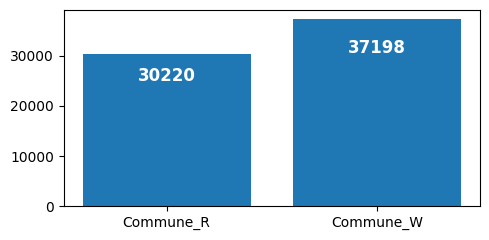

In [6]:
# Plot the values of 7777
GCoR_comm_7777 = (y_df["GEO_COMM_RESID"] == 7777).sum()
GCoW_comm_7777 = (y_df["GEO_COMM_WORK"] == 7777).sum()

labels = ["Commune_R", "Commune_W"]
values = [GCoR_comm_7777,GCoW_comm_7777]

plt.figure(figsize=(5, 2.5))
bars = plt.bar(labels, values)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,height - height*0.2, str(height), ha='center',va='bottom',color='white', fontweight='bold',fontsize = 12)
    
plt.tight_layout()
plt.show()

In [7]:
# Rename municipality columns
y_df = y_df.rename(columns={"GEO_COMM_RESID": "commune_1","GEO_COMM_WORK": "commune_2", "VALUE": "flow"})

# Drop all values of '7777'
y_df = y_df[(y_df["commune_1"] != 7777) & (y_df["commune_2"] != 7777)]

# Drop the values of Perspective 'W'
y_df = y_df[y_df["PERSPECTIVE"] == "R"]
y_df = y_df.drop(columns ="PERSPECTIVE" )

# Transform all columns to numeric
y_df = y_df.apply(pd.to_numeric, errors='coerce')
y_df = y_df.rename(columns={'REF_YEAR': 'year'})

y_df.head()

,year,GEO_CANT_RESID,commune_1,GEO_CANT_WORK,commune_2,flow
0,2014,1,1,1,1,147
1,2014,1,1,1,2,106
2,2014,1,1,1,3,5
3,2014,1,1,1,4,7
4,2014,1,1,1,5,8


In [8]:
# Prepare pairs of municipalities to fill up the y data
cities = communes_code['commune_code'].apply(pd.to_numeric, errors='coerce')  # all commune IDs
pairs = list(itertools.permutations(cities, 2)) #orderd pairs
all_combinations = pd.DataFrame(pairs, columns=['commune_1', 'commune_2'])

# Add the years we are using
years = pd.DataFrame({'year': [2018, 2020]})
y_df = y_df.rename(columns={'REF_YEAR': 'year'})
all_combinations_years = (all_combinations.merge(years, how='cross'))

# Merge with existing flow data
y_full = pd.merge(all_combinations_years,y_df,on=['commune_1', 'commune_2', 'year'],how='left')
y_full = y_full[["commune_1", "commune_2",  "flow", "year"]]

# Fill missing flows with 0
y_full['flow'] = y_full['flow'].fillna(0)


# Data collection - canton

## GDP

In [9]:
# Load data for gdp for each canton
full_path = os.path.join(base_path, 'C_BIP_PERS_germ.xlsx')
gdp = pd.read_excel(full_path, skiprows=2)  
gdp = gdp.iloc[1:27][['Kanton',2014, 2018, 2020]].reset_index(drop=True)
gdp = gdp.rename(columns={'Kanton': 'canton'})
gdp.head()

,canton,2014,2018,2020
0,Zürich,144486.87809,156883.07738,149208.52863
1,Bern,78705.81482,80775.78955,80589.16775
2,Luzern,26004.33257,27792.86656,28039.73666
3,Uri,1873.05108,1962.56,1981.76975
4,Schwyz,9017.99038,9720.14955,10021.33084


In [10]:
gdp = gdp.melt(id_vars='canton', value_vars=[2014, 2018, 2020], var_name='year', value_name='gdp')

## Unemployment rate

In [11]:
regions = ['Genferseeregion',
           'Espace Mittelland',
           'Nordwestschweiz',
           'Ostschweiz',
           'Zentralschweiz']

In [12]:
# Load data for unemployment for each canton
full_path = os.path.join(base_path, 'C_Unemployment_germ.xlsx')
unemploy = pd.read_excel(full_path, skiprows=1) 
unemploy.drop(unemploy[unemploy['Kantone'].isin(regions)].index, inplace=True)
unemploy = unemploy.iloc[2:][['Kantone', 2014, 2018, 2020]].reset_index(drop=True)
unemploy=unemploy.rename(columns={'Kantone': 'canton'})
unemploy.head()

,canton,2014,2018,2020
0,Waadt,18238.166667,15081.416667,18783.333333
1,Wallis,6772.75,5388,6658.166667
2,Genf,12817.25,10633.333333,12154.583333
3,Bern,13189.333333,10763.75,14134.75
4,Freiburg,4408.833333,4455.25,5758


In [13]:
unemploy = unemploy.melt(id_vars='canton', value_vars=[2014, 2018, 2020], var_name='year', value_name='unemployment')
unemploy = unemploy.dropna()

## Cantons dataframe

In [14]:
# Merge the dataframes of cantonal data
dfs = [unemploy, gdp] 

cantons = reduce(lambda left, right: pd.merge(left, right, on=['canton', 'year'], how='outer'), dfs)
cantons.head()

,canton,year,unemployment,gdp
0,Aargau,2014,10137.916667,41857.04587
1,Aargau,2018,9734.916667,43687.13571
2,Aargau,2020,12802.583333,44108.19224
3,Appenzell A. Rh.,2014,532.916667,3099.52196
4,Appenzell A. Rh.,2018,461.083333,3201.04029


In [15]:
# Keep only official cantons and rename them all the same
new_names = sorted(cantons_code['canton'].dropna().unique())
old_names = sorted(cantons['canton'].unique())

replace_dict = dict(zip(old_names, new_names))

# Only keep the cantons
cantons = cantons[cantons['canton'].isin(replace_dict.keys())]
cantons['canton'] = cantons['canton'].replace(replace_dict)
cantons.head()

,canton,year,unemployment,gdp
0,Aargau,2014,10137.916667,41857.04587
1,Aargau,2018,9734.916667,43687.13571
2,Aargau,2020,12802.583333,44108.19224
3,Appenzell Ausserrhoden,2014,532.916667,3099.52196
4,Appenzell Ausserrhoden,2018,461.083333,3201.04029


# Communal

## Area and population

In [16]:
# Prepared the data with QGIS, as otherwise the data was too heavy.
file_2020 =  os.path.join(base_path, 'Com_AREA_POP_2020.xlsx')
file_2018 = os.path.join(base_path, 'Com_AREA_POP_2018.xlsx')

# Load data about Area and Population
area_pop_2020 = pd.read_excel(file_2020)
area_pop_2018 = pd.read_excel(file_2018)

area_pop_2020['year'] = 2020
area_pop_2018['year'] = 2018

# Put the data together
area_pop = pd.concat([area_pop_2020, area_pop_2018], ignore_index=True)
area_pop = area_pop.rename(columns={"NAME": "commune_name"})
area_pop = area_pop[area_pop["EINWOHNERZ"] != 0] 
area_pop = area_pop[["BFS_NUMMER", "commune_name", "GEM_FLAECH", "EINWOHNERZ", "year"]]
area_pop.head()


,BFS_NUMMER,commune_name,GEM_FLAECH,EINWOHNERZ,year
0,3762,Scuol,43861,4591,2020
1,1631,Glarus Süd,43003,9494,2020
2,3746,Zernez,34404,1527,2020
3,3543,Surses,32377,2356,2020
5,6031,Bagnes,28410,8096,2020


## Traffic accidents

In [17]:
# Load files about traffic accidents in CH
file_2020 =  os.path.join(base_path, 'Com_Autounfalle_2020.xlsx')
file_2018 = os.path.join(base_path, 'Com_Autounfalle_2018.xlsx')

files = [file_2018, file_2020]
years = [2018, 2020]

all_accidents = []

for year, file in zip(years, files):  
    xls = pd.read_excel(file, sheet_name=None)

    sheet_names = list(xls.keys())

    df_first = pd.read_excel(file, sheet_name=sheet_names[0])
    columns = df_first.columns 
    dfs = []

    for i, name in enumerate(sheet_names):
        if i == 0:
            df = pd.read_excel(file, sheet_name=name)
        else:
            df = xls[name]
            df.columns = columns
        df["sheet"] = name
        dfs.append(df)

    accidents_voit = pd.concat(dfs, ignore_index=True)
    accidents_voit = accidents_voit[5:].reset_index(drop=True)
    accidents_voit["year"] = year

    all_accidents.append(accidents_voit)

accidents_voit = pd.concat(all_accidents, ignore_index=True)


In [18]:
# Liste des colonnes en français
accidents_voit = accidents_voit.drop(columns= {'sheet'})

columns = [
    "commune_name",
    "Accidents dégâts matériels",
    "Accidents avec dommages corporels",
    "Morts",
    "blessés graves",
    "danger de vie",
    "blessés sérieux",
    "Accidents légers",
    'year'
]

accidents_voit.columns = columns

# Keep only columns we want to keep
accidents_voit = accidents_voit[[
    "commune_name",
    "Accidents dégâts matériels",
    "Accidents avec dommages corporels",
    "Morts",
    "year"
]]

accidents_voit = accidents_voit[accidents_voit["commune_name"] != 'Total']
accidents_voit.head()

,commune_name,Accidents dégâts matériels,Accidents avec dommages corporels,Morts,year
0,Aadorf,16,11,0,2018
1,Aarau,49,47,0,2018
2,Aarberg,26,12,0,2018
3,Aarburg,17,13,0,2018
4,Aarwangen,10,15,0,2018


## Gender and Nationality

In [19]:
# Load files with data for gender and nationality distribution
file_2020 =  os.path.join(base_path, 'Com_GENDER_NATIONAL_2020.xlsx')
file_2018 = os.path.join(base_path, 'Com_GENDER_NATIONAL_2018.xlsx')

df_2020 = pd.read_excel(file_2020,  skiprows=5, header=None)
df_2018 = pd.read_excel(file_2018,  skiprows=5, header=None)

df_2020['year'] = 2020
df_2018['year'] = 2018

df_gend_nat = pd.concat([df_2018, df_2020], ignore_index=True)

df_gend_nat.columns = ["Commune", 
              "T_Total", "T_Mann", "T_Frau", "CH_Mann", "CH_Frau", "CH_Total",
              "Etr_Mann", "Etr_Frau", "Etr_Total","year"]


In [20]:
# Clean the data 
df_gend_nat = cleaning_stat_data(df_gend_nat)

# drop columns that are added unncessarely => columns where there are no values
df_gend_nat = df_gend_nat[~df_gend_nat['T_Frau'].isna()]

# Keep only essential columns
df_gend_nat = df_gend_nat[['T_Mann', 'T_Frau', 'Etr_Total', 'commune_name', 'canton', 'year']]

/Users/leilapaolini/Documents/GitHub/ML_Projet_2/functions.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Code', 'commune_name']] = data['Commune'].str.replace(r'^[.\s]+', '', regex=True)\
/Users/leilapaolini/Documents/GitHub/ML_Projet_2/functions.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Code', 'commune_name']] = data['Commune'].str.replace(r'^[.\s]+', '', regex=True)\


## Age

In [21]:
# Load file about age distribution in municipalities
file =  os.path.join(base_path, 'Com_ALTER.xlsx')

df_age_2020 = pd.read_excel(file, skiprows=3, header=None, sheet_name="2020")
df_age_2018 = pd.read_excel(file, skiprows=3, header=None, sheet_name="2018")
df_age_2014 = pd.read_excel(file, skiprows=3, header=None, sheet_name="2014")

df_age_2020['year'] = 2020
df_age_2018['year'] = 2018

df_age = pd.concat([
    df_age_2018, df_age_2020], ignore_index=True)

/opt/anaconda3/envs/ml/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/opt/anaconda3/envs/ml/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/opt/anaconda3/envs/ml/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [22]:
# Clean data
df_age = df_age.rename(columns={0: "Commune"})
df_age = cleaning_stat_data(df_age)
df_age = df_age.dropna(subset=[1])
df_age = df_age.drop(columns={1})

/Users/leilapaolini/Documents/GitHub/ML_Projet_2/functions.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Code', 'commune_name']] = data['Commune'].str.replace(r'^[.\s]+', '', regex=True)\
/Users/leilapaolini/Documents/GitHub/ML_Projet_2/functions.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Code', 'commune_name']] = data['Commune'].str.replace(r'^[.\s]+', '', regex=True)\


In [23]:
# Add canton code => could also be done elsewhere
df_age['canton_code'] = df_age['canton'].map(canton_map)


In [24]:
# Regroup the age in intervals
age_intervals = {
    '0-25': list(range(0, 26)),    # ages 0 to 25 - students / lower working part
    '25-65': list(range(25, 66)),  # ages 25 to 65 - working
    '65+': list(range(65, 103))    # ages 65 to 102 - older, not working anymore
}

for label, ages in age_intervals.items():
    age_cols = [age for age in ages if age in df_age.columns]
    df_age[label] = df_age[age_cols].sum(axis=1)

In [25]:
# Keep only necessary columns
columns_to_keep = ['0-25', '25-65', '65+','commune_name','canton_code', 'year']
df_age = df_age[columns_to_keep]

df_age.head()

,0-25,25-65,65+,commune_name,canton_code,year
0,472.0,1156.0,393.0,Aeugst am Albis,1,2018
1,3062.0,6981.0,2472.0,Affoltern am Albis,1,2018
2,1532.0,3151.0,997.0,Bonstetten,1,2018
3,971.0,2072.0,739.0,Hausen am Albis,1,2018
4,984.0,2129.0,696.0,Hedingen,1,2018


# Merge

In [26]:
# Merge dataframes of communal data
dfs = [df_gend_nat, accidents_voit, area_pop, df_age]
df_com = reduce(lambda left, right: pd.merge(left, right, on=['commune_name', 'year'], how='outer'), dfs)

# Drop the rows where we don't have an attributed commune
df_com = df_com[~df_com['commune_name'].isna()]

df_com.head()


,T_Mann,T_Frau,Etr_Total,commune_name,canton,year,Accidents dégâts matériels,Accidents avec dommages corporels,Morts,BFS_NUMMER,GEM_FLAECH,EINWOHNERZ,0-25,25-65,65+,canton_code
0,4544.0,4493.0,646.0,Aadorf,Thurgau,2018,16,11,0,4551.0,1994.0,8865.0,2231.0,5115.0,1910.0,20
1,4637.0,4579.0,686,Aadorf,Thurgau,2020,12,8,0,4551.0,1994.0,9037.0,2267.0,5091.0,2081.0,20
2,10575.0,10931.0,2119.0,Aarau,Aargau,2018,49,47,0,4001.0,1234.0,21036.0,4529.0,13084.0,4384.0,19
3,10664.0,11062.0,2162,Aarau,Aargau,2020,43,45,0,4001.0,1234.0,21506.0,4612.0,13142.0,4413.0,19
4,2280.0,2348.0,246.0,Aarberg,Bern / Berne,2018,26,12,0,301.0,793.0,4527.0,1108.0,2574.0,1056.0,2


In [27]:
# Clean dataset
df_com = df_com[~df_com["commune_name"].str.contains('total', case=False, na=False)]


In [28]:
# We decided to drop those columns afterwards, as we wil continue with the BFS_NUMMER to merge on
print(df_com["commune_name"][df_com['BFS_NUMMER'].isna()])

445                 Bois-d'Amont
689        C'za Capriasca/Lugano
690        C'za Capriasca/Lugano
923                   Crans (VD)
1980                    Klosters
2050           La Grande Béroche
2051           La Grande Béroche
2576          Muntogna da Schons
2726               Noble-Contrée
3131                   Rheinwald
3696                   Stammheim
4028               Val de Bagnes
4271    Welschenrohr-Gänsbrunnen
Name: commune_name, dtype: object


In [29]:
'''BFS_NUMMER_DICT = {
    "La Grande Béroche": 6417,
    "C'za Capriasca/Lugano": None,
    "Rheinwald": 3714,
    "Stammheim": 292,
    "Bois-d'Amont": 2238,
    "Crans (VD)": 5713,
    "Klosters": 3871,
    "Muntogna da Schons": 3715,
    "Noble-Contrée": 6254,
    "Val de Bagnes": 6037,
    "Welschenrohr-Gänsbrunnen": 5819,
}
'''

'BFS_NUMMER_DICT = {\n    "La Grande Béroche": 6417,\n    "C\'za Capriasca/Lugano": None,\n    "Rheinwald": 3714,\n    "Stammheim": 292,\n    "Bois-d\'Amont": 2238,\n    "Crans (VD)": 5713,\n    "Klosters": 3871,\n    "Muntogna da Schons": 3715,\n    "Noble-Contrée": 6254,\n    "Val de Bagnes": 6037,\n    "Welschenrohr-Gänsbrunnen": 5819,\n}\n'

In [30]:
# Add cantonal dataset
df_features = df_com.merge(cantons, on=["canton", "year"], how="left")
df_features.head()

,T_Mann,T_Frau,Etr_Total,commune_name,canton,year,Accidents dégâts matériels,Accidents avec dommages corporels,Morts,BFS_NUMMER,GEM_FLAECH,EINWOHNERZ,0-25,25-65,65+,canton_code,unemployment,gdp
0,4544.0,4493.0,646.0,Aadorf,Thurgau,2018,16,11,0,4551.0,1994.0,8865.0,2231.0,5115.0,1910.0,20,4953.25,30521.09186
1,4637.0,4579.0,686,Aadorf,Thurgau,2020,12,8,0,4551.0,1994.0,9037.0,2267.0,5091.0,2081.0,20,6117.916667,29018.15979
2,10575.0,10931.0,2119.0,Aarau,Aargau,2018,49,47,0,4001.0,1234.0,21036.0,4529.0,13084.0,4384.0,19,9734.916667,43687.13571
3,10664.0,11062.0,2162,Aarau,Aargau,2020,43,45,0,4001.0,1234.0,21506.0,4612.0,13142.0,4413.0,19,12802.583333,44108.19224
4,2280.0,2348.0,246.0,Aarberg,Bern / Berne,2018,26,12,0,301.0,793.0,4527.0,1108.0,2574.0,1056.0,2,10763.75,80775.78955


In [31]:
# Drop the rows where canton is 0, or that don't have a BFS Nummer.
df_features = df_features.dropna(subset=['canton_code', 'BFS_NUMMER']).reset_index(drop=True)

# Drop the string columns
df_features = df_features.drop(columns = ['canton', 'commune_name'])

## NAN Values

In [32]:
df_features.isna().sum()

T_Mann                                0
T_Frau                                0
Etr_Total                             0
year                                  0
Accidents dégâts matériels           47
Accidents avec dommages corporels    47
Morts                                47
BFS_NUMMER                            0
GEM_FLAECH                            0
EINWOHNERZ                            0
0-25                                  0
25-65                                 0
65+                                   0
canton_code                           0
unemployment                          0
gdp                                   0
dtype: int64

In [33]:
# Apply Linear regression on features presenting nan values
df_features = df_features.apply(pd.to_numeric, errors='coerce')

cols_for_regression = ['Accidents dégâts matériels','Accidents avec dommages corporels','Morts', 'Etr_Total']

col_for_prediction = 'EINWOHNERZ'

df_features = Nan_regression(df_features, cols_for_regression, col_for_prediction)


## Create distance matrix

In [35]:
# Load canton geometries (prepared with QGIS, because it would have been too heavy otherwise)
file =  os.path.join(base_path, 'communes_2020.shp')

communes = gpd.read_file(file)

# Define CRS
communes = communes.to_crs(epsg=2056)

# Compute centroids
communes["centroid"] = communes.geometry.centroid
communes["cx"] = communes.centroid.x
communes["cy"] = communes.centroid.y

coords = communes[["cx", "cy"]].to_numpy()
names = communes["BFS_NUMMER"] 

# Compute distances
n = len(coords)
dist_matrix = pd.DataFrame(np.zeros((n, n)), index=names, columns=names)

for i in range(n):
    for j in range(i, n):                           # start at i, not 0
        d = Point(coords[i]).distance(Point(coords[j]))
        dist_matrix.iat[i, j] = d
        dist_matrix.iat[j, i] = d   

print(dist_matrix)

# Export in order to be able to load it afterwards faster
#output_path = "../data/commune_distance_matrix_nrs.npy"
output_path = os.path.join(base_path, 'commune_distance_matrix_nrs.npy')
# save only the matrix values
np.save(output_path, dist_matrix.to_numpy())

print(f"Distance matrix saved to {output_path}")



BFS_NUMMER           3762           1631           3746           3543  \
BFS_NUMMER                                                               
3762             0.000000   93088.897408   16176.956167   57582.201089   
1631         93088.897408       0.000000   81191.445696   59898.476502   
3746         16176.956167   81191.445696       0.000000   41406.890679   
3543         57582.201089   59898.476502   41406.890679       0.000000   
9758        287045.984906  199720.176624  272160.421217  234519.938972   
...                   ...            ...            ...            ...   
5588        277611.729896  189607.952162  262863.908855  225671.517181   
4651        131640.676832   82083.101825  129073.822358  130968.265729   
4308        166110.065930   86946.154890  158909.477472  146439.464880   
5609        270012.090021  182725.632371  255152.704003  217649.138160   
5394        122577.447712   92573.089845  106647.235946   66635.037741   

BFS_NUMMER           9758           6

# Plot Data

In [36]:
# Load the spatial municpiality data
communes["centroid"] = communes.geometry.centroid
communes = communes.rename(columns={"BFS_NUMMER": "GEO_COMM"})
communes.head()


,GEO_COMM,KANTONSNUM,NAME,geometry,centroid,cx,cy
0,3762,18.0,Scuol,"POLYGON Z ((2803369.136 1191207.211 3111.083, ...",POINT (2816858.336 1184634.05),2.816858e+06,1.184634e+06
1,1631,8.0,Glarus Süd,"POLYGON Z ((2712665.708 1185502.929 3605.123, ...",POINT (2724828.192 1198633.883),2.724828e+06,1.198634e+06
2,3746,18.0,Zernez,"POLYGON Z ((2803369.136 1191207.211 3111.083, ...",POINT (2802921.769 1176420.281),2.802922e+06,1.176420e+06
3,3543,18.0,Surses,"POLYGON Z ((2757700.559 1163421.151 2972.528, ...",POINT (2766900.831 1155999.149),2.766901e+06,1.155999e+06
4,9758,22.0,Lac Léman (VD),MULTIPOLYGON Z (((2508390.583 1137980.442 372....,POINT (2532679.796 1144162.396),2.532680e+06,1.144162e+06


In [37]:
# Prepare flow
flows = (
    y_df.merge(communes[["GEO_COMM", "centroid"]], 
               left_on="commune_1", right_on="GEO_COMM", how="left")
         .rename(columns={"centroid": "origin"})
         .merge(communes[["GEO_COMM", "centroid"]],
               left_on="commune_2", right_on="GEO_COMM", how="left")
         .rename(columns={"centroid": "destination"})
)


In [38]:
# Prepare flow
flows = flows.dropna()
flows["geometry"] = flows.apply(
    lambda row: LineString([row["origin"], row["destination"]]), axis=1
)

flow_gdf = gpd.GeoDataFrame(flows, geometry="geometry", crs=communes.crs)


In [39]:
# Export flows and commune data
flows.to_pickle("flows.pkl")
communes.to_pickle("communes.pkl")

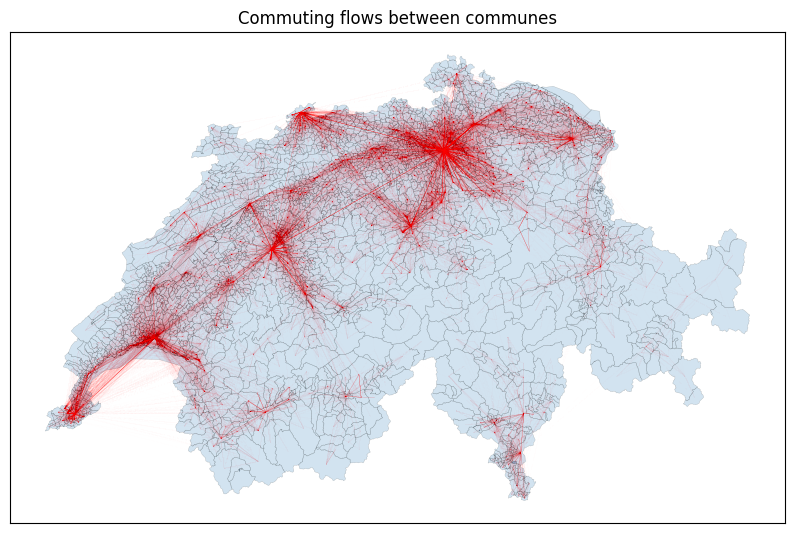

In [40]:
# Plot flow
fig, ax = plt.subplots(figsize=(10, 10))

communes.plot(ax=ax,linewidth=0.3,edgecolor="black",alpha=0.2         )

flow_gdf.plot(ax=ax,linewidth=(flow_gdf["flow"] / flow_gdf["flow"].max()) * 8, alpha=0.8,color="red"     )

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.title("Commuting flows between communes")
plt.show()


In [41]:
# All commune codes appearing in y_df
communes_in_flows = set(y_df["commune_1"]).union(
    set(y_df["commune_2"])
)

# Communes that do NOT appear in y_df
communes["missing_in_flows"] = ~communes["GEO_COMM"].isin(communes_in_flows)


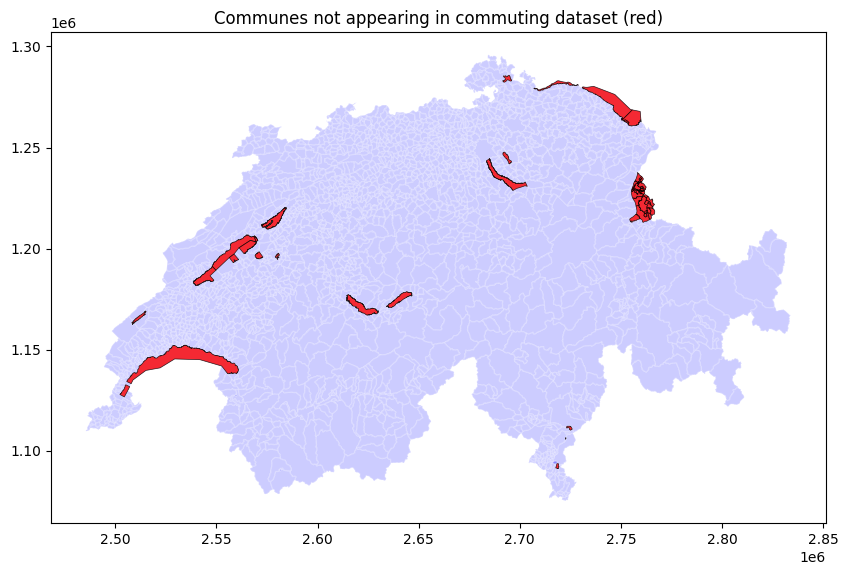

In [42]:
# Plot communes that have no flow at all
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all communes (light grey transparent)
communes.plot(
    ax=ax,
    color="blue",
    edgecolor="white",
    alpha=0.2
)

# Plot communes not appearing in y_df in RED
communes[communes["missing_in_flows"]].plot(
    ax=ax,
    color="red",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.8
)

plt.title("Communes not appearing in commuting dataset (red)")
plt.show()


# Final merge

In [43]:
# add distances to each pairs of communes
final_df = pd.DataFrame(pairs, columns=['commune_1', 'commune_2'])
final_df['distance'] = [dist_matrix.loc[c1, c2] for c1, c2 in pairs]
years = pd.DataFrame({'year': [2018, 2020]})

# Cartesian product between all pairs and all years
final_df = (final_df.merge(years, how='cross'))


In [44]:
pop_dict = dict(zip(df_features['BFS_NUMMER'], df_features['EINWOHNERZ']))

# Map population to commune_1
final_df['pop_1'] = final_df['commune_1'].map(pop_dict)

# If you also want population for commune_2
final_df['pop_2'] = final_df['commune_2'].map(pop_dict)


In [45]:

# Change dtype
df_features['BFS_NUMMER'] = df_features['BFS_NUMMER'].astype(int)

# add sociodemographic features to each pair of communes
final_df = final_df.merge(
    df_features,
    left_on=['commune_1', 'year'],
    right_on=['BFS_NUMMER', 'year'],
    how="left",
    suffixes=("", "_1")
)

final_df = final_df.merge(
    df_features,
    left_on=['commune_2', 'year'],
    right_on=['BFS_NUMMER', 'year'],
    how="left",
    suffixes=("", "_2")
)

final_df = final_df.drop(columns=["BFS_NUMMER", "BFS_NUMMER_2"])

final_df = final_df.dropna()

In [46]:
X_y = final_df.merge(
    y_full[["commune_1", "commune_2", "flow", "year"]],
    on=["commune_1", "commune_2", "year"],
    how="inner"
)

In [47]:
X_y.columns

Index(['commune_1', 'commune_2', 'distance', 'year', 'pop_1', 'pop_2',
       'T_Mann', 'T_Frau', 'Etr_Total', 'Accidents dégâts matériels',
       'Accidents avec dommages corporels', 'Morts', 'GEM_FLAECH',
       'EINWOHNERZ', '0-25', '25-65', '65+', 'canton_code', 'unemployment',
       'gdp', 'T_Mann_2', 'T_Frau_2', 'Etr_Total_2',
       'Accidents dégâts matériels_2', 'Accidents avec dommages corporels_2',
       'Morts_2', 'GEM_FLAECH_2', 'EINWOHNERZ_2', '0-25_2', '25-65_2', '65+_2',
       'canton_code_2', 'unemployment_2', 'gdp_2', 'flow'],
      dtype='object')

In [48]:
df_numeric = X_y.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.dropna()
np.save("data_y.npy", df_numeric.values)